# Movie Recommendation System

In [13]:
# importing libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
import gc
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score, make_scorer,log_loss
from sklearn.model_selection import KFold


Reading CSV files

In [15]:
df_ratings = pd.read_csv('Dataset/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id','movie_id','rating','timestamp'])
df_movies = pd.read_csv('Dataset/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id','title','genres'])
df_users = pd.read_csv('Dataset/users.csv', sep='\t', encoding='latin-1',  usecols=['user_id','gender','age','occupation','zipcode','age_desc','occ_desc'])

##  EDA for users

In [214]:
df_users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


Number of ratings by male and female

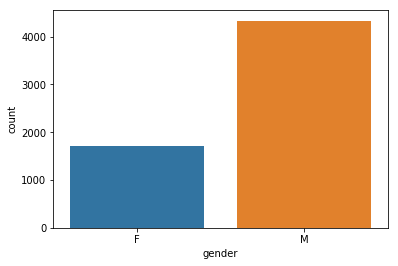

In [215]:
sns.countplot(df_users['gender'])

Number of ratings according to age

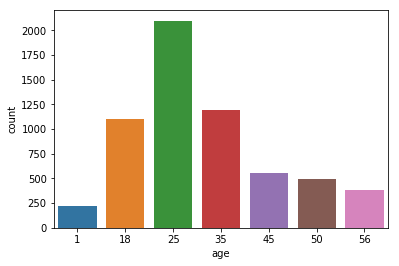

In [216]:
sns.countplot(df_users['age'])

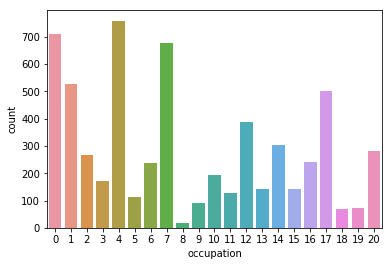

In [217]:
sns.countplot(df_users['occupation'])

From above count plot it can be concluded that age and gender could be important estimators as they are able to determine the distribution of ratings properly.

## EDA for movies

In [483]:
df_movies.head(30)

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
5,6,Heat (1995),"[Action, Crime, Thriller]"
6,7,Sabrina (1995),"[Comedy, Romance]"
7,8,Tom and Huck (1995),"[Adventure, Children's]"
8,9,Sudden Death (1995),[Action]
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]"


Determining the popularity on genres based on number of movies belonging to same genre. The below function calculates the number of movies for each genre.

In [470]:
# Make a census of the genre keywords
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels)
keyword_occurences[:]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

Spliting the genres separated by '|'

In [521]:
array=[]
array= df_movies['genres'].str.split('|')
df_movies['genres'] =array

In [412]:
df_movies.isnull().values.any()

False

In [413]:
df_ratings.isnull().values.any()

False

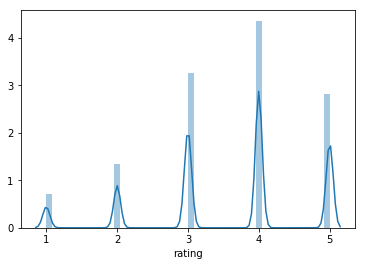

In [224]:
sns.distplot(df_ratings["rating"]);

The average ratings seem to be more generous as most of the ratings are 4.0

Merging all dataframes

In [414]:
dataset = pd.merge(pd.merge(df_movies, df_ratings),df_users)

In [477]:
dataset.head()

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,Toy Story (1995),"['[\'Animation\', ""Children\'s"", \'Comedy\']']",1,5,978824268,F,1,10,48067,Under 18,K-12 student
1,48,Pocahontas (1995),"['[\'Animation\', ""Children\'s"", \'Musical\', ...",1,5,978824351,F,1,10,48067,Under 18,K-12 student
2,150,Apollo 13 (1995),"[""['Drama']""]",1,5,978301777,F,1,10,48067,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),"[""['Action', 'Adventure', 'Fantasy', 'Sci-Fi']""]",1,4,978300760,F,1,10,48067,Under 18,K-12 student
4,527,Schindler's List (1993),"[""['Drama', 'War']""]",1,5,978824195,F,1,10,48067,Under 18,K-12 student


# Content based filtering
<hr>

Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. The user profile is represented with the same terms and built up by analyzing the content of items which have been seen by the user. A content based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc

<h3>Term Frequency (TF) and Inverse Document Frequency (IDF)</h3><br>
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).


In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_movies['genres'])
tfidf_matrix.shape

(3883, 127)

For finding similarity between the vectors we would be using Cosine Similarity. Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. With cosine similarity, we would find the similarity values for each movie and represent them in form of matrix. Currently we are using linear_kernel for finding cosine similarity.

<img src="Capture.JPG" alt="Drawing" style="width: 800px;"/>

In [228]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

The below function takes movie name as input, then we find the corresponding movie_id and then find similar scores of other movies with respect to that movie. Once we have values for similarity, sort it in descending order, and get the top similar fovies for recommendation

In [229]:
titles = df_movies['title']
indices = pd.Series(df_movies.index, index=df_movies['title'])
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [230]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

# Collaborative Filtering
<hr>

Collaborative filtering (CF) is a technique commonly used to build personalized recommendations on the Web. Some popular websites that make use of the collaborative filtering technology include Amazon, Netflix, iTunes, IMDB, LastFM, Delicious and StumbleUpon. In collaborative filtering, algorithms are used to make automatic predictions about a user's interests by compiling preferences from several users. 

For example, a site like Amazon may recommend that the customers who purchase books A and B purchase book C as well. This is done by comparing the historical preferences of those who have purchased the same books.

Different types of collaborative filtering are as follows:<br>
<ul>
<li>Memory Based: This method makes use of user rating information to calculate the likeness between the users or items. This calculated likeness is then used to make recommendations.</li><br>
<li>Model Based: Models are created by using data mining, and the system learns algorithms to look for habits according to training data. These models are then used to come up with predictions for actual data.</li><br>
    <li>Hybrid: Various programs combine the model-based and memory-based CF algorithms.</li></ul>

In [417]:
dataset.head(10)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,Toy Story (1995),"['[\'Animation\', ""Children\'s"", \'Comedy\']']",1,5,978824268,F,1,10,48067,Under 18,K-12 student
1,48,Pocahontas (1995),"['[\'Animation\', ""Children\'s"", \'Musical\', ...",1,5,978824351,F,1,10,48067,Under 18,K-12 student
2,150,Apollo 13 (1995),"[""['Drama']""]",1,5,978301777,F,1,10,48067,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),"[""['Action', 'Adventure', 'Fantasy', 'Sci-Fi']""]",1,4,978300760,F,1,10,48067,Under 18,K-12 student
4,527,Schindler's List (1993),"[""['Drama', 'War']""]",1,5,978824195,F,1,10,48067,Under 18,K-12 student
5,531,"Secret Garden, The (1993)","['[""Children\'s"", \'Drama\']']",1,4,978302149,F,1,10,48067,Under 18,K-12 student
6,588,Aladdin (1992),"['[\'Animation\', ""Children\'s"", \'Comedy\', \...",1,4,978824268,F,1,10,48067,Under 18,K-12 student
7,594,Snow White and the Seven Dwarfs (1937),"['[\'Animation\', ""Children\'s"", \'Musical\']']",1,4,978302268,F,1,10,48067,Under 18,K-12 student
8,595,Beauty and the Beast (1991),"['[\'Animation\', ""Children\'s"", \'Musical\']']",1,5,978824268,F,1,10,48067,Under 18,K-12 student
9,608,Fargo (1996),"[""['Crime', 'Drama', 'Thriller']""]",1,4,978301398,F,1,10,48067,Under 18,K-12 student


Finding the null values in user_id and movie_id and replacing it with 0. Null values in ratings are replaced by average values.

In [419]:
df_ratings['user_id'] = df_ratings['user_id'].fillna(0)
df_ratings['movie_id'] = df_ratings['movie_id'].fillna(0)
 

In [420]:
print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
movie_id      1000209 non-null int64
title         1000209 non-null object
genres        1000209 non-null object
user_id       1000209 non-null int64
rating        1000209 non-null int64
timestamp     1000209 non-null int64
gender        1000209 non-null object
age           1000209 non-null int64
occupation    1000209 non-null int64
zipcode       1000209 non-null object
age_desc      1000209 non-null object
occ_desc      1000209 non-null object
dtypes: int64(6), object(6)
memory usage: 99.2+ MB
None


This dataset is very huge, our system might run out of memory while performing further computations. So we will perform out operatons on small fraction of dataset

In [422]:
small_data = df_ratings.sample(frac=0.02)
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 668330 to 890000
Data columns (total 4 columns):
user_id      20004 non-null int64
movie_id     20004 non-null int64
rating       20004 non-null int64
timestamp    20004 non-null int64
dtypes: int64(4)
memory usage: 781.4 KB
None


## Item-Item Colaborative Filtering
<hr>

<img src="item.JPG" alt="Drawing" style="width: 800px;"/>

In [428]:
ratings_matrix_items = dataset.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape


(3706, 6040)

In [237]:
ratings_matrix_items

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The ratings_matrix_items holds the ratings for movies by users in form of matrix
Here we are using pairwise_distances to calculate how different every movie is using cosine metric. This difference is subtracted from '1' to get their value for similarity. We are filling the diagonal values with 0 as originally its value is '1' and it should not be returned when we want the value with highest similarity.

In [530]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

C:\Users\mihir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.000000,0.999996,0.999994,0.999998,0.999992,1.000000,0.999999,0.999996,0.999977,0.999995,...,0.999965,0.999909,0.999923,0.999990,0.999925,0.999999,0.999982,0.999962,0.999858,0.999986
1,0.999996,0.000000,1.000000,0.999993,0.999999,0.999996,0.999996,0.999998,0.999992,1.000000,...,0.999944,0.999890,0.999933,0.999987,0.999896,0.999992,0.999964,0.999940,0.999818,0.999970
2,0.999994,1.000000,0.000000,0.999992,1.000000,0.999994,0.999995,0.999999,0.999993,0.999999,...,0.999940,0.999891,0.999939,0.999987,0.999889,0.999991,0.999960,0.999936,0.999813,0.999966
3,0.999998,0.999993,0.999992,0.000000,0.999991,0.999998,0.999999,0.999996,0.999972,0.999991,...,0.999973,0.999927,0.999934,0.999994,0.999936,0.999999,0.999987,0.999971,0.999876,0.999990
4,0.999992,0.999999,1.000000,0.999991,0.000000,0.999992,0.999994,0.999998,0.999995,0.999999,...,0.999934,0.999884,0.999937,0.999984,0.999881,0.999989,0.999956,0.999930,0.999804,0.999962
5,1.000000,0.999996,0.999994,0.999998,0.999992,0.000000,0.999999,0.999996,0.999977,0.999995,...,0.999966,0.999912,0.999926,0.999991,0.999927,0.999999,0.999982,0.999964,0.999860,0.999986
6,0.999999,0.999996,0.999995,0.999999,0.999994,0.999999,0.000000,0.999998,0.999978,0.999995,...,0.999966,0.999915,0.999930,0.999992,0.999926,0.999999,0.999982,0.999963,0.999860,0.999986
7,0.999996,0.999998,0.999999,0.999996,0.999998,0.999996,0.999998,0.000000,0.999987,0.999997,...,0.999956,0.999914,0.999948,0.999994,0.999909,0.999995,0.999972,0.999952,0.999843,0.999976
8,0.999977,0.999992,0.999993,0.999972,0.999995,0.999977,0.999978,0.999987,0.000000,0.999993,...,0.999896,0.999843,0.999930,0.999967,0.999833,0.999969,0.999923,0.999891,0.999742,0.999931
9,0.999995,1.000000,0.999999,0.999991,0.999999,0.999995,0.999995,0.999997,0.999993,0.000000,...,0.999940,0.999885,0.999931,0.999985,0.999889,0.999991,0.999961,0.999936,0.999811,0.999967


The below function takes movie name as input and appends the value of similarity with that movie to 'df_movies'

In [431]:
def SimilarItems(movieName): 
    try:
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]
        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Movie not there")

The following function first forms a list of movies which user has already watched and has rated 4.5 or 5 i.e. 'user_movie'. Then it sorts the df_movie according to values of similarity and then select ratings with similarity value more than 0.45. Then a new dataframe 'df_recommended_item' is created to which we will append only those movies which have high similarity values but the user hasnt seen.

In [440]:
def recommendedMovies_ItemSimilarity(user_id):
    user_movie= dataset[(dataset.user_id==user_id) & dataset.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    SimilarItems(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['user_id']== user_id]['movie_id']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movie_id==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movie_id']

In [437]:
def getTitle(listMovieIDs):
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [438]:
print("Movies to recommend,:\n",movieIdToTitle(recommendedMovies_ItemSimilarity(12)))

Movies to recommend,:
 [2243    Children of a Lesser God (1986)
Name: title, dtype: object, 2243    Children of a Lesser God (1986)
Name: title, dtype: object, 585    Terminator 2: Judgment Day (1991)
Name: title, dtype: object, 819    First Wives Club, The (1996)
Name: title, dtype: object, 2243    Children of a Lesser God (1986)
Name: title, dtype: object, 585    Terminator 2: Judgment Day (1991)
Name: title, dtype: object, 1553    In the Company of Men (1997)
Name: title, dtype: object, 1384    Scream (1996)
Name: title, dtype: object, 2243    Children of a Lesser God (1986)
Name: title, dtype: object]


## User-Item Colaborative filtering

<img src="Capture1.JPG" alt="Drawing" style="width: 800px;"/>

In the user-based approach the algorithm produces a rating for an item i by a user u by combining the ratings of other users u' that are similar to u. Similar here means that the two user's ratings have a high Pearson correlation or cosine similarity or something similar.

In [534]:
ratings_matrix_items = dataset.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape


(3706, 6040)

In [535]:
ratings_matrix_items

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As done previously, we will find user_similarity

In [536]:
user_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( user_similarity, 0 )
ratings_matrix_user = pd.DataFrame( user_similarity )
ratings_matrix_user

C:\Users\mihir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
1,0.390349,0.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
2,0.267943,0.240946,0.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
3,0.178789,0.155457,0.192788,0.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
4,0.256569,0.249970,0.308290,0.271990,0.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835
5,0.347373,0.244827,0.187020,0.125170,0.148114,0.000000,0.184966,0.055532,0.172145,0.418485,...,0.089106,0.025354,0.017274,0.112076,0.087213,0.236447,0.201419,0.115331,0.029136,0.222836
6,0.301490,0.262772,0.292230,0.220024,0.305107,0.184966,0.000000,0.049023,0.083145,0.248029,...,0.066875,0.051497,0.037842,0.065268,0.051835,0.191689,0.117660,0.059262,0.036102,0.138879
7,0.125709,0.196521,0.092122,0.049554,0.095512,0.055532,0.049023,0.000000,0.045263,0.107235,...,0.028519,0.072446,0.064868,0.059819,0.066350,0.090387,0.080523,0.084976,0.072141,0.045523
8,0.106620,0.158469,0.128378,0.060334,0.138392,0.172145,0.083145,0.045263,0.000000,0.216823,...,0.046188,0.014033,0.020523,0.103986,0.049767,0.092347,0.099554,0.004956,0.000000,0.057881
9,0.377459,0.386200,0.245601,0.133707,0.237681,0.418485,0.248029,0.107235,0.216823,0.000000,...,0.072576,0.049577,0.041950,0.121969,0.090955,0.237227,0.136374,0.097170,0.018359,0.161396


In [537]:
ratings_matrix_user.idxmax(axis=1).sample( 10 )

3224    3505
453      397
2298    2383
1302    1497
2812     662
3060     782
1079    1344
2180    1456
1312    3129
2092     256
dtype: int64

In [538]:
similar_user_series= ratings_matrix_user.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user

,similarUser
0,2898
1,3256
2,3218
3,1488
4,572
5,2086
6,329
7,544
8,1381
9,1575


The following function takes user_id as input and recommends movie based on user similarity

In [450]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    user2Movies= df_ratings[df_ratings['user_id']== userId]['movie_id']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame()
    for movieId in df_ratings[df_ratings['user_id']== sim_user]['movie_id']:
        if movieId not in user2Movies:
            df_new= dataset[(dataset.user_id==sim_user) & (dataset.movie_id==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movie_id']

In [451]:
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(12))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[2326    Rushmore (1998)
Name: title, dtype: object, 1178    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object, 1023    Die Hard (1988)
Name: title, dtype: object, 1797    Big Hit, The (1998)
Name: title, dtype: object, 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, 1482    Austin Powers: International Man of Mystery (1...
Name: title, dtype: object, 2460    Planet of the Apes (1968)
Name: title, dtype: object, 2623    Run Lola Run (Lola rennt) (1998)
Name: title, dtype: object, 1695    Wag the Dog (1997)
Name: title, dtype: object]


In [528]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [527]:
weight=0
for m in df_movies['movie_id']:    
    for GEN in df_movies[df_movies['movie_id']==m]['genres']:
        if 'Drama' in GEN:
            weight=weight+0.412
            df_movies[df_movies['movie_id']==m]['weight']=weight


C:\Users\mihir\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Hybrid Model

In [1]:
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
#fetch data and format
data = fetch_movielens(min_rating = 0.5)

#print training and testing data
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [3]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [4]:
#create model
model = LightFM(loss='warp')
#train model
model.fit(data['train'], epochs = 30, num_threads=2)

In [5]:
def sample_recommendation(model, data, user_ids):

    #number of users and movies in training data
    n_users, n_items = data['train'].shape

    #generate recommendations for each user input
    for user_id in user_ids: 

        #movies they always like
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        #movies the model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))
        #rank in order of most liked to least
        top_items = data['item_labels'][np.argsort(-scores)]

        #print results
        print("User %s" % user_id)
        print("         Known positives:")

        for x in known_positives[:3]:
            print("          %s" % x)
        
        print("         Recommend:")

        for x in top_items[:3]:
            print("         %s" % x)

In [6]:
sample_recommendation(model, data, [10, 30, 25, 34, 450])

User 10
         Known positives:
          Babe (1995)
          Dead Man Walking (1995)
          Seven (Se7en) (1995)
         Recommend:
         Sleepless in Seattle (1993)
         Empire Strikes Back, The (1980)
         Back to the Future (1985)
User 30
         Known positives:
          Crumb (1994)
          Fugitive, The (1993)
          Lone Star (1996)
         Recommend:
         English Patient, The (1996)
         Full Monty, The (1997)
         Boogie Nights (1997)
User 25
         Known positives:
          Toy Story (1995)
          Twelve Monkeys (1995)
          Dead Man Walking (1995)
         Recommend:
         Fargo (1996)
         Liar Liar (1997)
         Independence Day (ID4) (1996)
User 34
         Known positives:
          Contact (1997)
          Mimic (1997)
          Kull the Conqueror (1997)
         Recommend:
         Air Force One (1997)
         Contact (1997)
         G.I. Jane (1997)
User 450
         Known positives:
          Kolya (1996)
  

In [7]:
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
auc_train = auc_score(model, data['train']).mean()
auc_test = auc_score(model, data['test']).mean()

In [8]:
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

Train AUC Score: 0.9471908211708069
Test AUC Score: 0.9084656834602356


## K-Mean Clustering

Exploring the similarities and differences in people's tastes in movies based on how they rate different movies.
Aim to gain understanding of these ratings contribution to a movie recommendation system for users.

In [16]:
df_movies.groupby('genres')['movie_id']

In [18]:
df_movies.genres.unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

Getting the list of all unique genres present in our dataset

In [54]:
# Make a census of the genre keywords
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    """
    Function that counts the number of times each of the genre keywords appear
    """
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [20]:
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels)
keyword_occurences[:100]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

Occurence of each movies genre along with the count value

In [55]:
def movie_genre_ratings(ratings, movies, genres, column_names):
    """
    Return dataframe containing average value 
    of each genre rating given by a particular user. 
    """
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movie_id'].isin(genre_movies['movie_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    print(genre_ratings)
    genre_ratings.columns = column_names
    return genre_ratings

Taking subset of users, and passing the subset of genres values for each we would get the average value of each genre rating given by a particular user. 

In [25]:
genre_ratings = movie_genre_ratings(df_ratings, df_movies, ['Romance','Drama','Action','Crime','War','Comedy','Thriller','Horror','Adventure','Documentary','Musical','Mysetry','Animation','Fantasy','Western','Film-Noir', 'Sci-Fi'], ['avg_romance_rating', 'avg_Drama_rating','avg_Action_rating','avg_Crime_rating','avg_War_rating','avg_Comedy_rating','avg_Thriller_rating','avg_Horror_rating','avg_Adventure_rating','avg_Documentary_rating','avg_Musical_rating','avg_Mysetry_rating','avg_Animation_rating','avg_Fantasy_rating','avg_Western_rating','avg_Film-Noir_rating','avg_Sci-Fi_rating'])
genre_ratings.head()

         rating  rating  rating  rating  rating  rating  rating  rating  \
user_id                                                                   
1          3.67    4.43    4.20    4.00    5.00    4.14    3.67     NaN   
2          3.71    3.90    3.50    3.58    3.73    3.56    3.48    3.00   
3          3.80    4.00    3.96     NaN    4.00    3.77    3.80    2.67   
4          4.00    4.17    4.16    5.00    3.33     NaN    3.50    4.33   
5          3.10    3.10    2.61    3.29    3.50    3.41    2.85    2.80   
6          4.00    3.73    4.00    3.00    4.00    3.75    3.67     NaN   
7          4.00    4.00    4.31    4.00    4.75    4.33    4.60    5.00   
8          4.07    3.81    4.03    4.00    4.20    3.89    4.03    5.00   
9          3.56    3.89    3.50    3.75    4.14    3.74    3.63    2.00   
10         4.37    4.18    3.91    3.60    3.83    4.14    4.22    4.00   
11         3.09    3.69    3.56    4.43    3.75    3.17    3.44    3.00   
12         3.00    4.33  

,avg_romance_rating,avg_Drama_rating,avg_Action_rating,avg_Crime_rating,avg_War_rating,avg_Comedy_rating,avg_Thriller_rating,avg_Horror_rating,avg_Adventure_rating,avg_Documentary_rating,avg_Musical_rating,avg_Mysetry_rating,avg_Animation_rating,avg_Fantasy_rating,avg_Western_rating,avg_Film-Noir_rating,avg_Sci-Fi_rating
user_id,,,,,,,,,,,,,,,,,
1,3.67,4.43,4.20,4.00,5.00,4.14,3.67,NaN,4.00,NaN,4.29,NaN,4.11,4.0,NaN,NaN,4.33
2,3.71,3.90,3.50,3.58,3.73,3.56,3.48,3.00,3.74,NaN,NaN,NaN,NaN,3.0,4.33,4.0,3.59
3,3.80,4.00,3.96,NaN,4.00,3.77,3.80,2.67,4.00,NaN,4.00,NaN,4.00,4.5,4.67,NaN,3.83
4,4.00,4.17,4.16,5.00,3.33,NaN,3.50,4.33,3.83,NaN,NaN,NaN,NaN,4.5,4.50,NaN,3.56
5,3.10,3.10,2.61,3.29,3.50,3.41,2.85,2.80,3.00,3.67,3.33,NaN,4.00,NaN,4.00,4.0,3.07


In [26]:
avg_FilmNoir_rating_array = genre_ratings[genre_ratings["avg_Film-Noir_rating"]!=np.nan]["avg_Film-Noir_rating"]
genre_ratings['avg_Film-Noir_rating']=genre_ratings["avg_Film-Noir_rating"].replace(np.nan,avg_FilmNoir_rating_array.mean())

avg_SciFi_rating_array = genre_ratings[genre_ratings["avg_Sci-Fi_rating"]!=np.nan]["avg_Sci-Fi_rating"]
genre_ratings['avg_Sci-Fi_rating']=genre_ratings["avg_Sci-Fi_rating"].replace(np.nan,avg_SciFi_rating_array.mean())

avg_Western_rating_array = genre_ratings[genre_ratings["avg_Western_rating"]!=np.nan]["avg_Western_rating"]
genre_ratings['avg_Western_rating']=genre_ratings["avg_Western_rating"].replace(np.nan,avg_Western_rating_array.mean())

avg_Fantasy_rating_array = genre_ratings[genre_ratings["avg_Fantasy_rating"]!=np.nan]["avg_Fantasy_rating"]
genre_ratings['avg_Fantasy_rating']=genre_ratings["avg_Fantasy_rating"].replace(np.nan,avg_Fantasy_rating_array.mean())

avg_Animation_rating_array = genre_ratings[genre_ratings["avg_Animation_rating"]!=np.nan]["avg_Animation_rating"]
genre_ratings['avg_Animation_rating']=genre_ratings["avg_Animation_rating"].replace(np.nan,avg_Animation_rating_array.mean())

avg_Musical_rating_array = genre_ratings[genre_ratings["avg_Musical_rating"]!=np.nan]["avg_Musical_rating"]
genre_ratings['avg_Musical_rating']=genre_ratings["avg_Musical_rating"].replace(np.nan,avg_Musical_rating_array.mean())

avg_Documentary_rating_array = genre_ratings[genre_ratings["avg_Documentary_rating"]!=np.nan]["avg_Documentary_rating"]
genre_ratings['avg_Documentary_rating']=genre_ratings["avg_Documentary_rating"].replace(np.nan,avg_Documentary_rating_array.mean())

avg_Adventure_rating_array = genre_ratings[genre_ratings["avg_Adventure_rating"]!=np.nan]["avg_Adventure_rating"]
genre_ratings['avg_Adventure_rating']=genre_ratings["avg_Adventure_rating"].replace(np.nan,avg_Adventure_rating_array.mean())

avg_Horror_rating_array = genre_ratings[genre_ratings["avg_Horror_rating"]!=np.nan]["avg_Horror_rating"]
genre_ratings['avg_Horror_rating']=genre_ratings["avg_Horror_rating"].replace(np.nan,avg_Horror_rating_array.mean())

avg_Thriller_rating_array = genre_ratings[genre_ratings["avg_Thriller_rating"]!=np.nan]["avg_Thriller_rating"]
genre_ratings['avg_Thriller_rating']=genre_ratings["avg_Thriller_rating"].replace(np.nan,avg_Thriller_rating_array.mean())

avg_Comedy_rating_array = genre_ratings[genre_ratings["avg_Comedy_rating"]!=np.nan]["avg_Comedy_rating"]
genre_ratings['avg_Comedy_rating']=genre_ratings["avg_Comedy_rating"].replace(np.nan,avg_Comedy_rating_array.mean())

avg_War_rating_array = genre_ratings[genre_ratings["avg_War_rating"]!=np.nan]["avg_War_rating"]
genre_ratings['avg_War_rating']=genre_ratings["avg_War_rating"].replace(np.nan,avg_War_rating_array.mean())

avg_Crime_rating_array = genre_ratings[genre_ratings["avg_Crime_rating"]!=np.nan]["avg_Crime_rating"]
genre_ratings['avg_Crime_rating']=genre_ratings["avg_Crime_rating"].replace(np.nan,avg_Crime_rating_array.mean())

avg_Drama_rating_array = genre_ratings[genre_ratings["avg_Drama_rating"]!=np.nan]["avg_Drama_rating"]
genre_ratings['avg_Drama_rating']=genre_ratings["avg_Drama_rating"].replace(np.nan,avg_Drama_rating_array.mean())

avg_romance_rating_array = genre_ratings[genre_ratings["avg_romance_rating"]!=np.nan]["avg_romance_rating"]
genre_ratings['avg_romance_rating']=genre_ratings["avg_romance_rating"].replace(np.nan,avg_romance_rating_array.mean())

avg_Action_rating_array = genre_ratings[genre_ratings["avg_Action_rating"]!=np.nan]["avg_Action_rating"]
genre_ratings['avg_Action_rating']=genre_ratings["avg_Action_rating"].replace(np.nan,avg_Action_rating_array.mean())

We can see their are lot of NaN values in the result set.<br>
Replacing the NaN value with the mean value of each genre category to proceed with K-mean clustering.

In [27]:
genre_ratings.isnull().sum()

avg_romance_rating           0
avg_Drama_rating             0
avg_Action_rating            0
avg_Crime_rating             0
avg_War_rating               0
avg_Comedy_rating            0
avg_Thriller_rating          0
avg_Horror_rating            0
avg_Adventure_rating         0
avg_Documentary_rating       0
avg_Musical_rating           0
avg_Mysetry_rating        6040
avg_Animation_rating         0
avg_Fantasy_rating           0
avg_Western_rating           0
avg_Film-Noir_rating         0
avg_Sci-Fi_rating            0
dtype: int64

We can see the NaN value corresponding to each column has been reduced to 0.

In [28]:
genre_ratings = genre_ratings.drop(['avg_Mysetry_rating'], axis=1)

Since 'avg_Mysetry_rating' contains the maximum NaN values, so we are dropping the column.

In [29]:
genre_ratings.head()

,avg_romance_rating,avg_Drama_rating,avg_Action_rating,avg_Crime_rating,avg_War_rating,avg_Comedy_rating,avg_Thriller_rating,avg_Horror_rating,avg_Adventure_rating,avg_Documentary_rating,avg_Musical_rating,avg_Animation_rating,avg_Fantasy_rating,avg_Western_rating,avg_Film-Noir_rating,avg_Sci-Fi_rating
user_id,,,,,,,,,,,,,,,,
1,3.67,4.43,4.20,4.000000,5.00,4.140000,3.67,3.329908,4.00,3.849692,4.290000,4.110000,4.000000,3.626505,4.012227,4.33
2,3.71,3.90,3.50,3.580000,3.73,3.560000,3.48,3.000000,3.74,3.849692,3.682836,3.695711,3.000000,4.330000,4.000000,3.59
3,3.80,4.00,3.96,3.769433,4.00,3.770000,3.80,2.670000,4.00,3.849692,4.000000,4.000000,4.500000,4.670000,4.012227,3.83
4,4.00,4.17,4.16,5.000000,3.33,3.638193,3.50,4.330000,3.83,3.849692,3.682836,3.695711,4.500000,4.500000,4.012227,3.56
5,3.10,3.10,2.61,3.290000,3.50,3.410000,2.85,2.800000,3.00,3.670000,3.330000,4.000000,3.579163,4.000000,4.000000,3.07


In [57]:
#Importing the KMeans library
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=16, random_state=0)
predictions = kmeans_1.fit_predict(genre_ratings)

Importing the KMeans library and applying the algorithm when no of clusters, k = 16

In [58]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    """
    Function to plot the clustering graphically
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_Sci-Fi_rating'], clustered['avg_romance_rating'] ,c=clustered['group'], s=20, cmap=cmap)

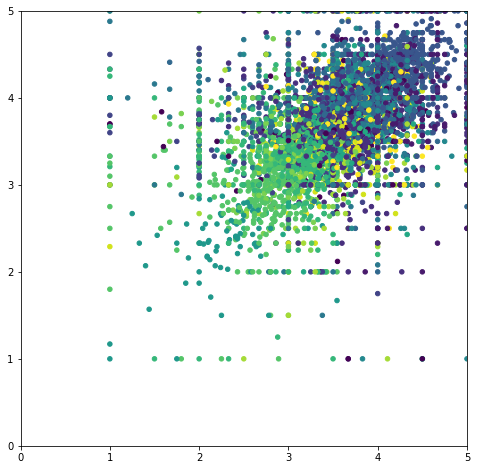

In [32]:
draw_clusters(genre_ratings,predictions,cmap='viridis')

Since the no. of dimensions are more than 2 so we can see clearly the clusters in 2D plane.

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    """
    Functions created to evaluate the model performance 
    """
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

Silhouette value indicates the best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [34]:
print(len(genre_ratings)+1)

6041


In [35]:
possible_k_values = range(2, 100, 5)

errors_per_k = [clustering_errors(k, genre_ratings) for k in possible_k_values]

Calculating the optimal value of k in the range from 2 to 100.

In [36]:
list(zip(possible_k_values, errors_per_k))

[(2, 0.21152400722992779),
 (7, 0.07518315445950274),
 (12, 0.07020394489462448),
 (17, 0.056425058400490696),
 (22, 0.0567671567377317),
 (27, 0.04513456304853568),
 (32, 0.04515209584334357),
 (37, 0.04416722044363509),
 (42, 0.037361054040074615),
 (47, 0.03891024566097499),
 (52, 0.039963922780844215),
 (57, 0.03579499671199816),
 (62, 0.03875246552393328),
 (67, 0.033650026712913624),
 (72, 0.0304777950930251),
 (77, 0.0348930860791281),
 (82, 0.031030241040738326),
 (87, 0.029968845956644653),
 (92, 0.028778577417765083),
 (97, 0.03178557189613121)]

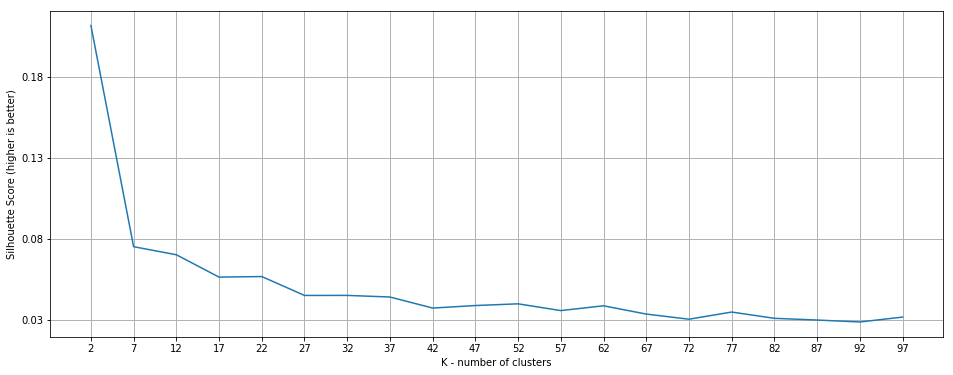

In [61]:
# Plotting the elbow curve for different value of k
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Looking at this graph, good choices for k include 7, 22, 27, amongst other values (with a slight variation between different runs). Increasing the number of clusters (k) beyond that range starts to result in worse clusters (according to Silhouette score)

The more data we give to k-means, the more similar the tastes of the people in each group would be. Unfortunately, though, we lose the ability to visualize what's going on past two or three dimensions if we continue to plot it this way.

### Movie Based Clustering

After seeing how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies.

In [62]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    """
    Function that returns the dataframe containing user who provide maximum rating
    and the movie with maximum ratings
    """
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [39]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [40]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [42]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(df_ratings, df_movies[['movie_id', 'title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (6040, 3706) 

Subset example:


title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957)
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called "sparse" because only a small number of cells have values.

In [43]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,American Beauty (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993),Saving Private Ryan (1998),Terminator 2: Judgment Day (1991),"Matrix, The (1999)",Back to the Future (1985),"Silence of the Lambs, The (1991)",...,E.T. the Extra-Terrestrial (1982),Star Wars: Episode I - The Phantom Menace (1999),Being John Malkovich (1999),"Shawshank Redemption, The (1994)","Godfather, The (1972)",Forrest Gump (1994),Ghostbusters (1984),Pulp Fiction (1994),"Terminator, The (1984)",Toy Story (1995)
4577,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0
5053,3.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0
4883,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,...,5.0,2.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0
1634,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,...,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0
1631,4.0,5.0,5.0,5.0,3.0,4.0,2.0,2.0,3.0,3.0,...,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0


Sorted by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    """
    Function to visualize ratings so we can attempt to visually recognize the ratings
    """    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

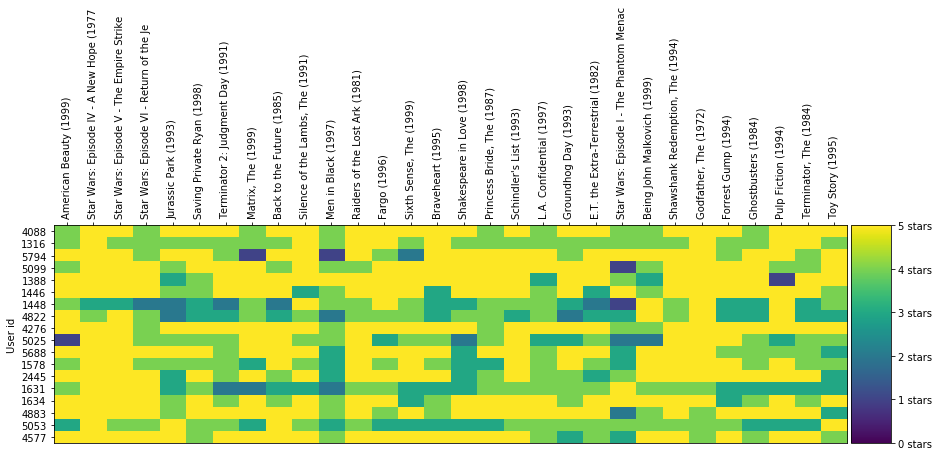

In [46]:
draw_movies_heatmap(most_rated_movies_users_selection)

Visualizing ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets.

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

In [45]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [47]:
from scipy.sparse import csr_matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

In [48]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20

In [49]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

Pick a cluster and a specific user and see what useful things this clustering will allow us to do.

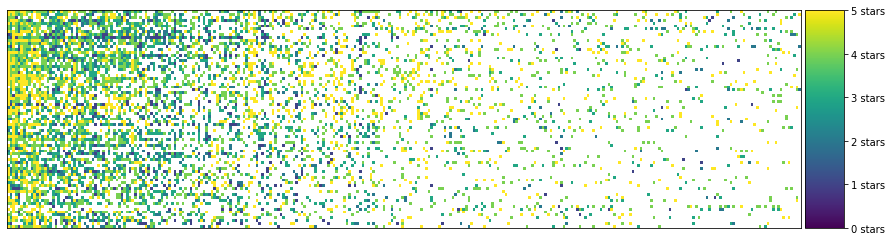

In [50]:
# Pick a cluster ID from the clusters above
cluster_number = 4

n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [51]:
cluster.fillna('').head()

,American Beauty (1999),Austin Powers: The Spy Who Shagged Me (1999),"Sixth Sense, The (1999)",American Pie (1999),"Blair Witch Project, The (1999)",Ghostbusters (1984),Being John Malkovich (1999),Who Framed Roger Rabbit? (1988),"Bug's Life, A (1998)",Fight Club (1999),...,Nikita (La Femme Nikita) (1990),Poltergeist (1982),Blade (1998),Wallace & Gromit: The Best of Aardman Animation (1996),12 Angry Men (1957),"Close Shave, A (1995)",Ace Ventura: Pet Detective (1994),"Fish Called Wanda, A (1988)","Wedding Singer, The (1998)",Con Air (1997)
103,5,5,5,4,4,5,5,4,4,3,...,4,,,,,,,,,
228,5,4,5,4,3,4,5,4,,5,...,,,,,,,,3,,5
80,4,4,4,1,,4,,,4,5,...,,,,,4,,3,,,
222,4,5,5,5,4,3,4,2,1,3,...,,,5,,,,,,,
76,5,3,5,4,3,5,4,5,4,4,...,,,5,,,,,,,


In [52]:
movie_name = 'Shakespeare in Love (1998)'

cluster[movie_name].mean()

4.2592592592592595

In [53]:
movie_name = 'Blair Witch Project, The (1999)'
cluster[movie_name].mean()

3.203125

Pick a blank cell from the table. It's blank because that user did not rate that movie. <br>
Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film

In [64]:
cluster.mean().head(20)

American Beauty (1999)                          4.367647
Austin Powers: The Spy Who Shagged Me (1999)    3.608696
Sixth Sense, The (1999)                         4.537313
American Pie (1999)                             3.803030
Blair Witch Project, The (1999)                 3.203125
Ghostbusters (1984)                             4.224138
Being John Malkovich (1999)                     4.245902
Who Framed Roger Rabbit? (1988)                 3.983607
Bug's Life, A (1998)                            3.725490
Fight Club (1999)                               4.161290
Shakespeare in Love (1998)                      4.259259
Clerks (1994)                                   4.084746
Gladiator (2000)                                4.192982
Bowfinger (1999)                                3.384615
Election (1999)                                 3.938776
Big Daddy (1999)                                3.340909
Talented Mr. Ripley, The (1999)                 3.423077
General's Daughter, The (1999) 

The average rating of 20 movies as rated by the users in the cluster